*First compiled: May 2, 2017.*

## Myeloid progenitors of data of Paul *et al.*, Cell. (2015)

Hematopoiesis: trace myeloid and erythroid differentiation for data of [Paul *et al.*, (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

In [1]:
%config InlineBackend.figure_formats = ['retina']  # increase resolution on retina screens
import numpy as np
import matplotlib.pyplot as pl
import scanpy.api as sc

sc.sett.verbosity = 3                # amount of output
sc.sett.set_dpi(80)                  # low pixel number yields small inline figures
sc.logg.print_version_and_date()

Running Scanpy version 0.1+47.gb025e66 on 2017-06-04 16:59.


Get the raw gene expression.

In [2]:
def paul15_raw():
    filename = 'data/paul15/paul15.h5'
    backup_url = 'http://falexwolf.de/data/paul15.h5'
    adata = sc.read(filename, 'data.debatched', backup_url=backup_url)
    # each row has to correspond to a sample, therefore transpose                                                                                                               
    adata = adata.transpose()    # cluster assocations identified by Paul et al.
    clusters = sc.read(filename, 'cluster.id', return_dict=True)['X'].flatten()
    if False:
        # the original cluster names
        adata.smp['paul15_clusters'] = ['C{}'.format(i) for i in clusters.astype(int)]
    else:
        # names reflecting the cell type identifications from the paper
        cell_types = {i: 'Ery' for i in range(1, 7)}
        cell_types[7] = 'MEP'
        cell_types[8] = 'Mk'
        cell_types[9] = 'GMP'
        cell_types[10] = 'GMP'
        cell_types[11] = 'DC'
        cell_types[12] = 'Baso'
        cell_types[13] = 'Baso'
        cell_types[14] = 'Mo'
        cell_types[15] = 'Mo'
        cell_types[16] = 'Neu'
        cell_types[17] = 'Neu'
        cell_types[18] = 'Eos'
        cell_types[19] = 'Other'
        adata.smp['paul15_clusters'] = [str(i) + cell_types[i] for i in clusters.astype(int)]
    infogenes_names = sc.read(filename, 'info.genes_strings', return_dict=True)['X']
    # just keep the first of the two equivalent names per gene                                                                                                                       
    adata.var_names = np.array([gn.split(';')[0] for gn in adata.var_names])
    # remove 10 corrupted gene names                                                                                                                                                 
    infogenes_names = np.intersect1d(infogenes_names, adata.var_names)
    # restrict the data to the 3461 informative genes                                                                                                                              
    adata = adata[:, infogenes_names]
    return adata

### Simple DPT analysis

Perform a Diffusion Pseudotime analysis on raw data, as in [Haghverdi *et al.* (2016)](http://doi.org/10.1038/nmeth.3971). No preprocessing, only logarthmize the raw counts.

In [3]:
adata = paul15_raw()
# logarithmize data
sc.pp.log1p(adata)
# set root cell as in Haghverdi et al. (2016)                                                                                                                                    
adata.var['xroot'] = adata.X[840]  # note that other than in Matlab/R, counting starts at 1

... reading sheet data.debatched from file data/paul15/paul15.h5
... reading sheet cluster.id from file data/paul15/paul15.h5
... reading sheet info.genes_strings from file data/paul15/paul15.h5


In [4]:
sc.tl.dpt(adata, n_branchings=1, k=20, n_pcs=0)

initializing data graph
... using X for building graph
... set iroot 840
start computing Diffusion Map
... determined k = 20 nearest neighbors of each point (0:00:00.625)
... computed W (weight matrix) with "knn" = True (0:00:01.142)
... computed K (anisotropic kernel) (0:00:00.019)
... computed Ktilde (normalized anistropic kernel)
... computed eigenvalues (0:00:00.036)
[ 1.     0.992  0.966  0.94   0.927  0.886  0.867  0.841  0.829  0.807]
perform Diffusion Pseudotime analysis
... detect 1 branching
... do not consider groups with less than 50 points for splitting
... branching 1: split group 0 with tip cells = [1687 2156  877] (0:00:00.003)
finished (0:00:00.593) and added
    "dpt_pseudotime", stores pseudotime (adata.smp),
    "dpt_groups", the segments of trajectories a long a tree (adata.smp),
    "dpt_groups_adjacency", the adjacency matrix between segments that defines the tree (adata.add),
    "dpt_order", is an index array for sorting the cells (adata.smp),
    "dpt_grouptip

Diffusion Pseudotime (DPT) analysis detects the branch of granulocyte/macrophage progenitors (GMP), and the branch of megakaryocyte/erythrocyte progenitors (MEP). There are two small further subgroups (segments 0 and 2).

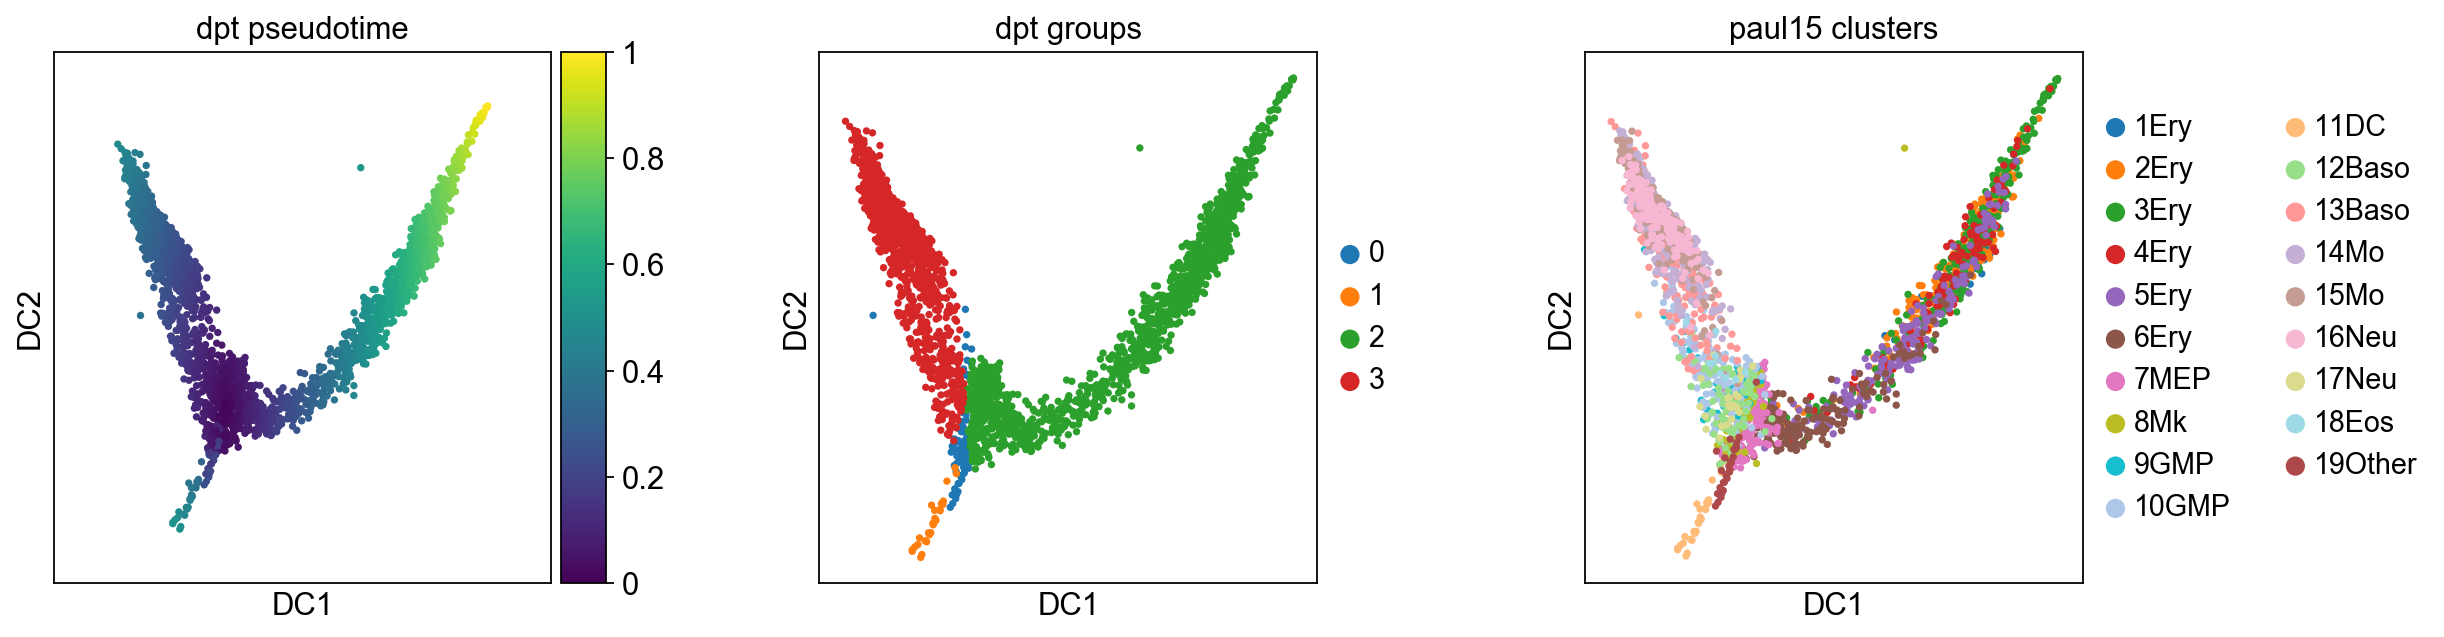

In [5]:
sc.pl.dpt_scatter(adata, color=['dpt_pseudotime', 'dpt_groups', 'paul15_clusters'])

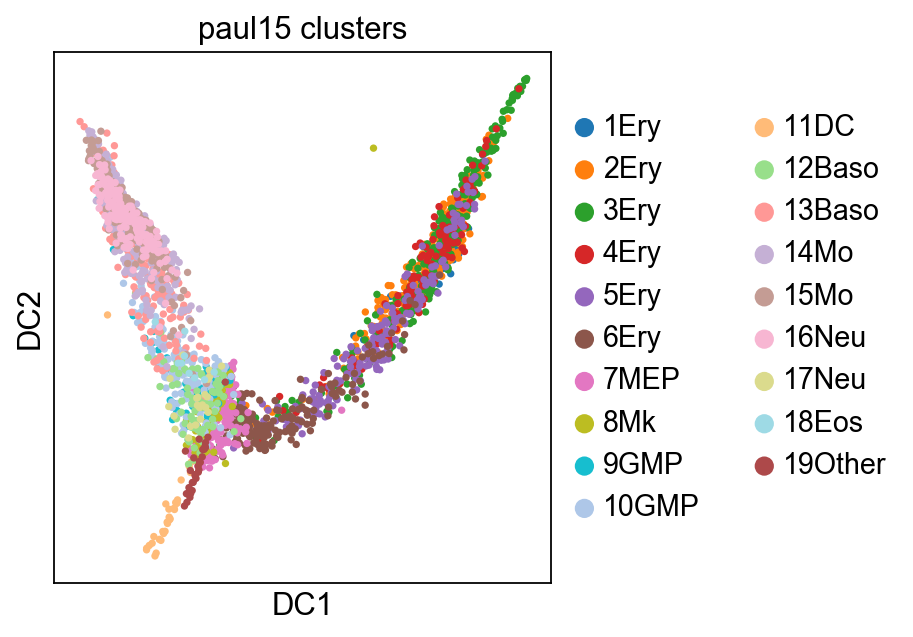

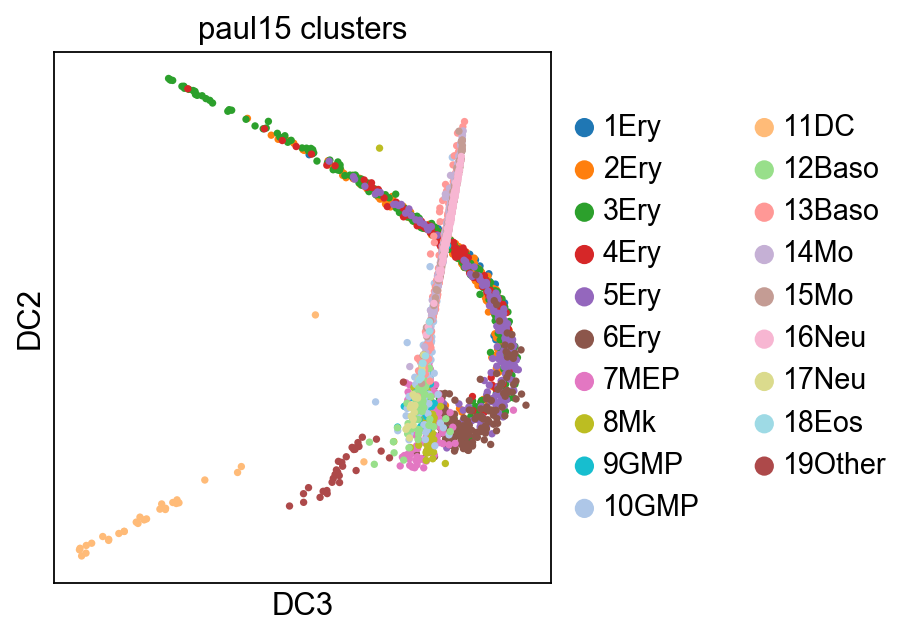

In [6]:
axs = sc.pl.diffmap(adata, color='paul15_clusters', comps=['1,2', '3,2'])

In [7]:
sc.tl.dpt(adata, n_branchings=2, k=20, n_pcs=0)

initializing data graph
... using X for building graph
... set iroot 840
... using `X_diffmap` for distance computations
perform Diffusion Pseudotime analysis
... detect 2 branchings
... do not consider groups with less than 50 points for splitting
... branching 1: split group 0 with tip cells = [1687 2156  877] (0:00:00.002)
... branching 2: split group 0 with tip cells = [75 69 88] (0:00:00.590)
finished (0:00:00.020) and added
    "dpt_pseudotime", stores pseudotime (adata.smp),
    "dpt_groups", the segments of trajectories a long a tree (adata.smp),
    "dpt_groups_adjacency", the adjacency matrix between segments that defines the tree (adata.add),
    "dpt_order", is an index array for sorting the cells (adata.smp),
    "dpt_grouptips", stores the indices of tip cells (adata.add)


### Hierarchical DPT on highly-variables genes

Select highly variable genes as done by [Zheng *et al.*, (2017)](http://doi.org/10.1038/ncomms14049).

In [8]:
adata = paul15_raw()
sc.pp.recipe_zheng17(adata, plot=False)
adata.var['xroot'] = adata.X[840]

... reading sheet data.debatched from file data/paul15/paul15.h5
... reading sheet cluster.id from file data/paul15/paul15.h5
... reading sheet info.genes_strings from file data/paul15/paul15.h5
... filtered out 0 genes that are detected with less than 1 counts
... normalizing by total count per cell (0:00:00.012)
... filter highly varying genes by dispersion and mean (0:00:00.046)
    the 1000 top genes correspond to a normalized dispersion cutoff of 1.06631
... normalizing by total count per cell (0:00:00.004)


In [9]:
sc.tl.dpt(adata, n_branchings=5, k=20)

initializing data graph
... set iroot 840
... compute X_pca for building graph
compute PCA with n_comps = 50
finished (0:00:00.879) and added
    the data representation "X_pca" (adata.smp)
    the loadings "PC1", "PC2", ... (adata.var)
    the "pca_variance_ratio" (adata.add)
start computing Diffusion Map
... determined k = 20 nearest neighbors of each point (0:00:00.210)
... computed W (weight matrix) with "knn" = True (0:00:00.918)
... computed K (anisotropic kernel) (0:00:00.022)
... computed Ktilde (normalized anistropic kernel)
... computed eigenvalues (0:00:00.037)
[ 1.     0.99   0.968  0.956  0.939  0.913  0.879  0.875  0.867  0.841]
perform Diffusion Pseudotime analysis
... detect 5 branchings
... do not consider groups with less than 50 points for splitting
... branching 1: split group 0 with tip cells = [ 622 1798 2004] (0:00:00.014)
... branching 2: split group 1 with tip cells = [126  56 144] (0:00:00.671)
... branching 3: split group 3 with tip cells = [ 286 1557 1309] (

compute tSNE
... using X_pca for tSNE
... using 50 principal components
... using MulticoreTSNE
finished (0:00:06.735) and added
    "X_tsne" coordinates, the tSNE representation of X (adata.smp)


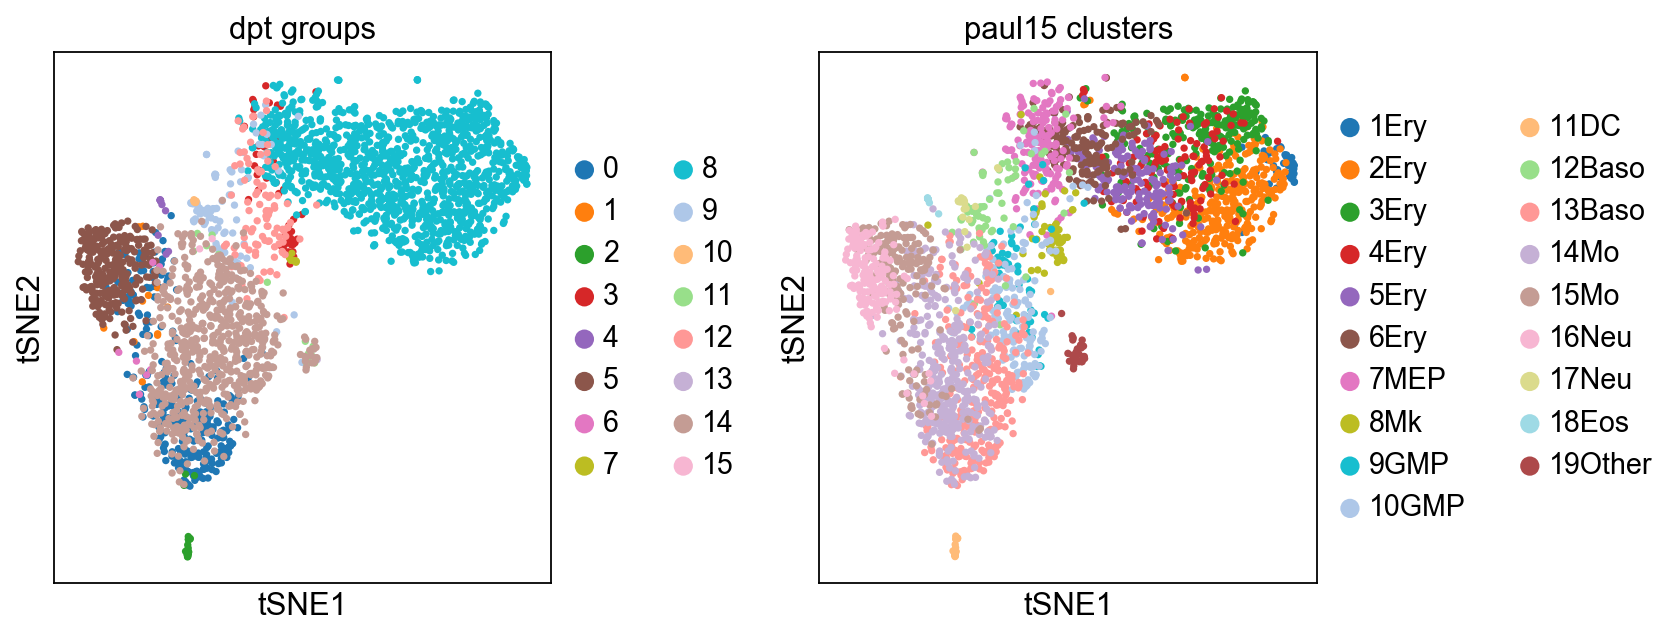

In [10]:
sc.tl.tsne(adata)
axs = sc.pl.tsne(adata, color=['dpt_groups', 'paul15_clusters'])

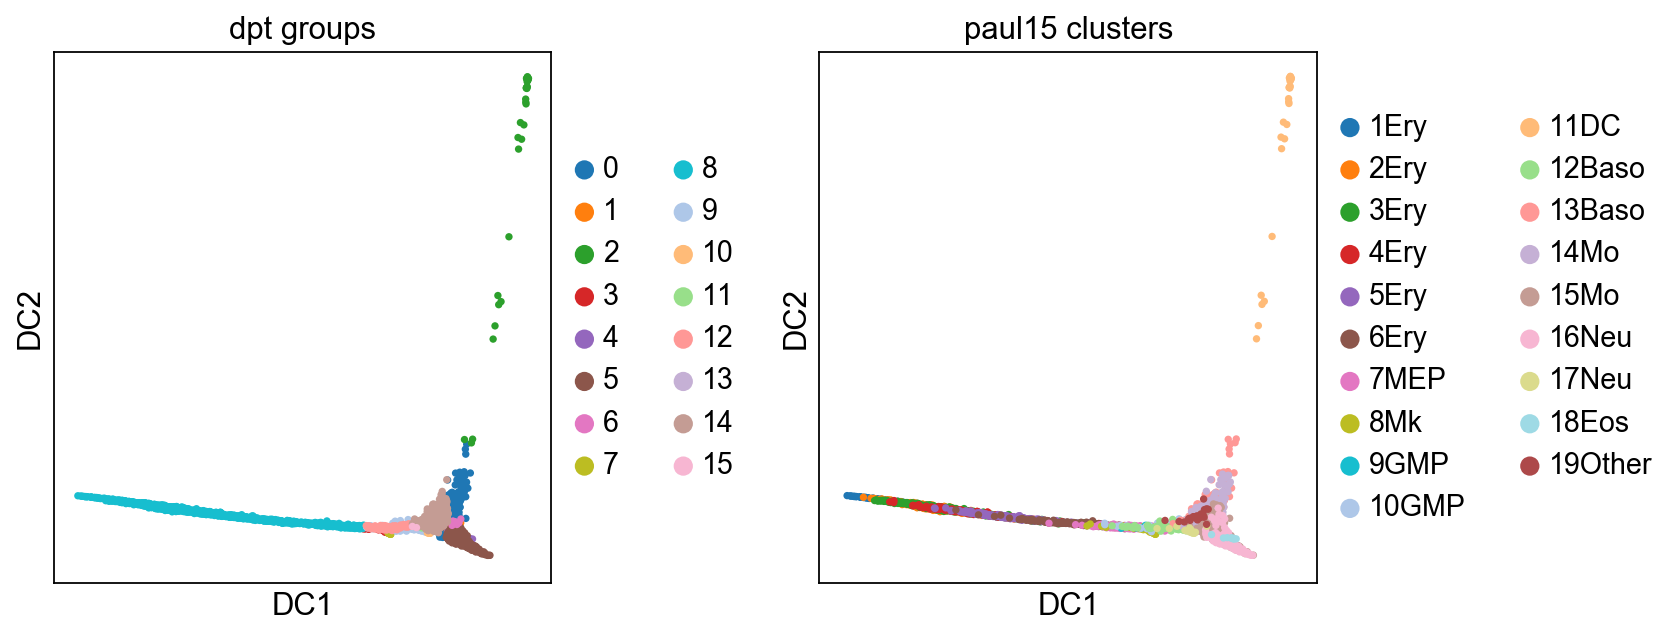

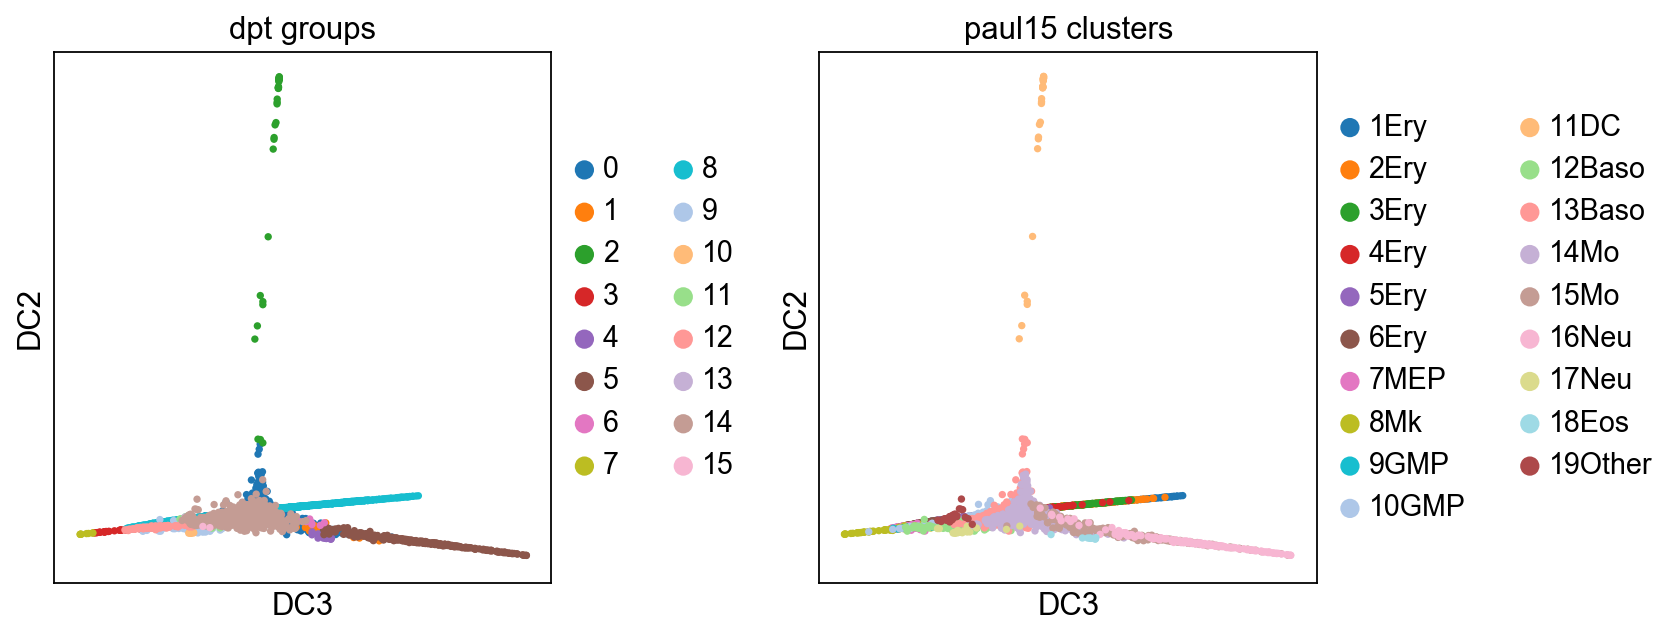

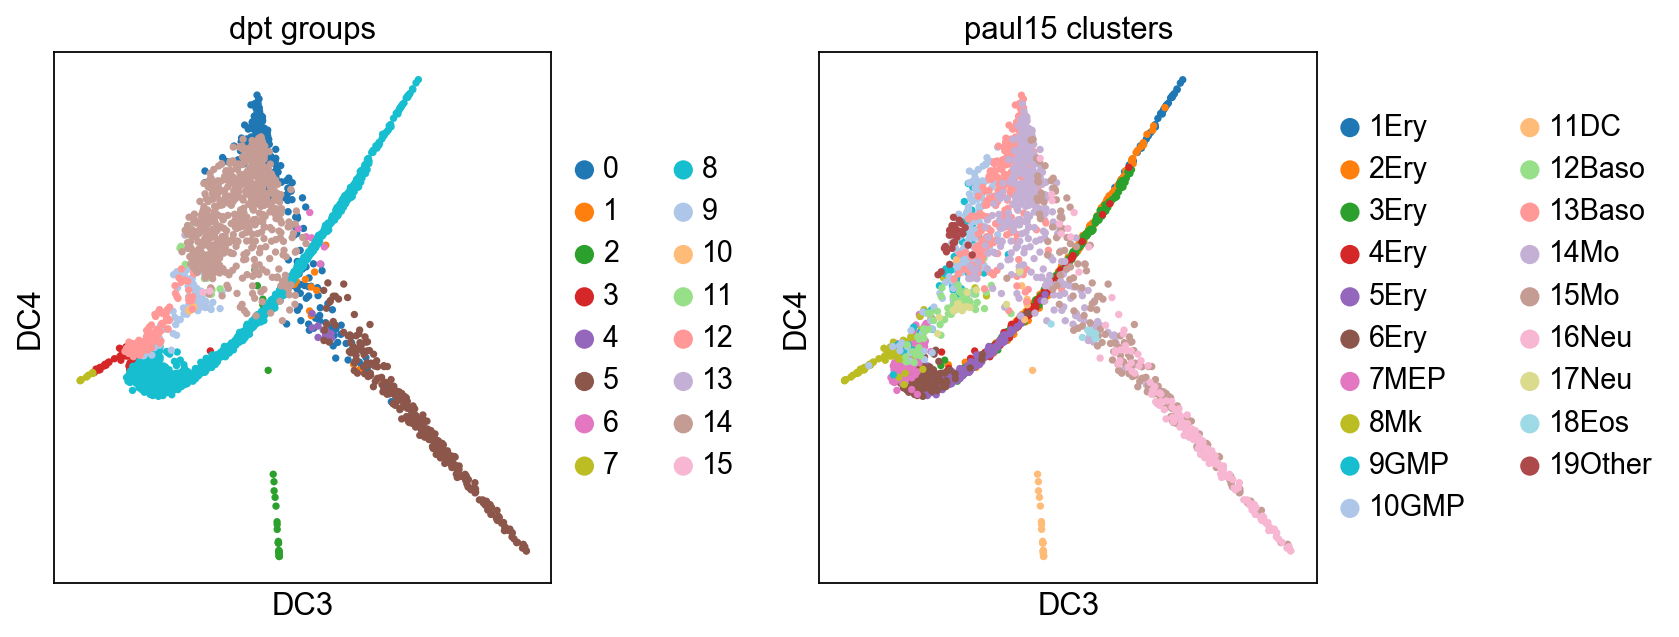

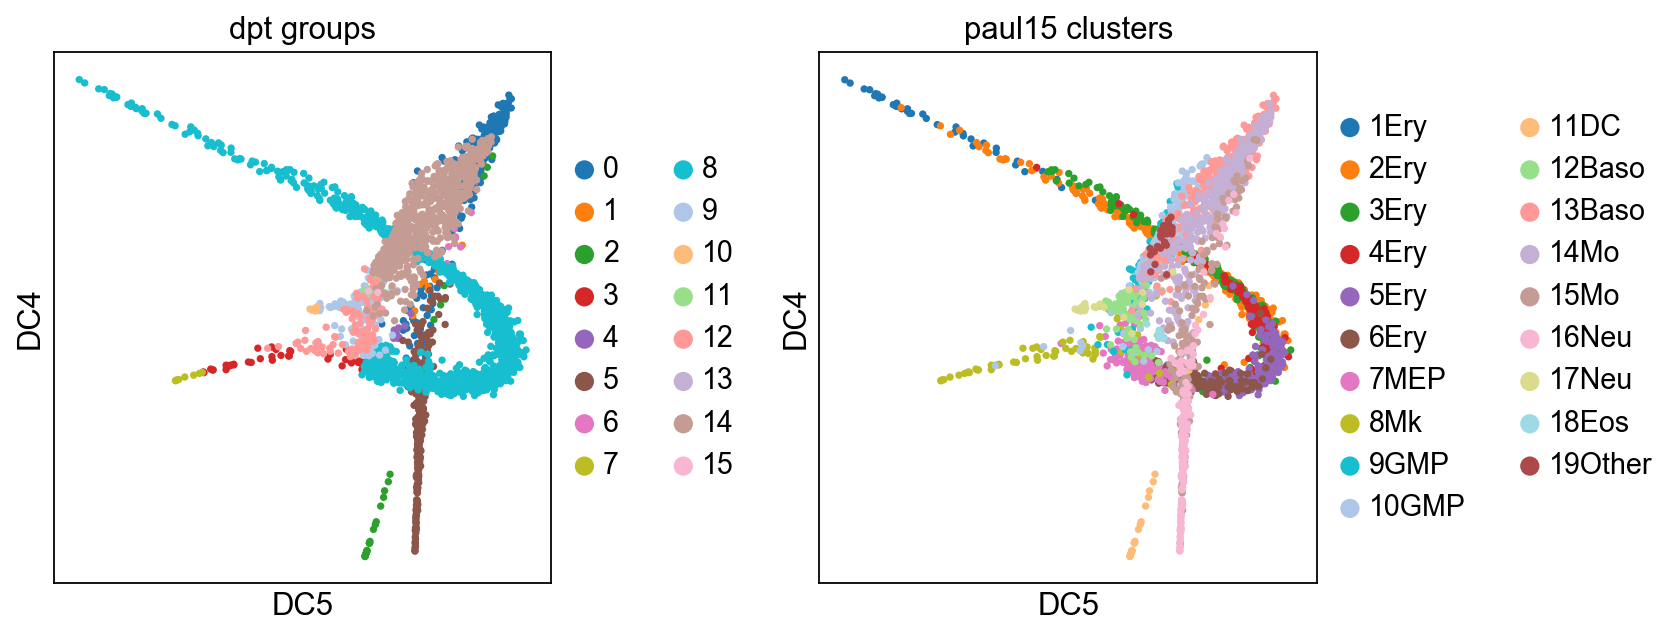

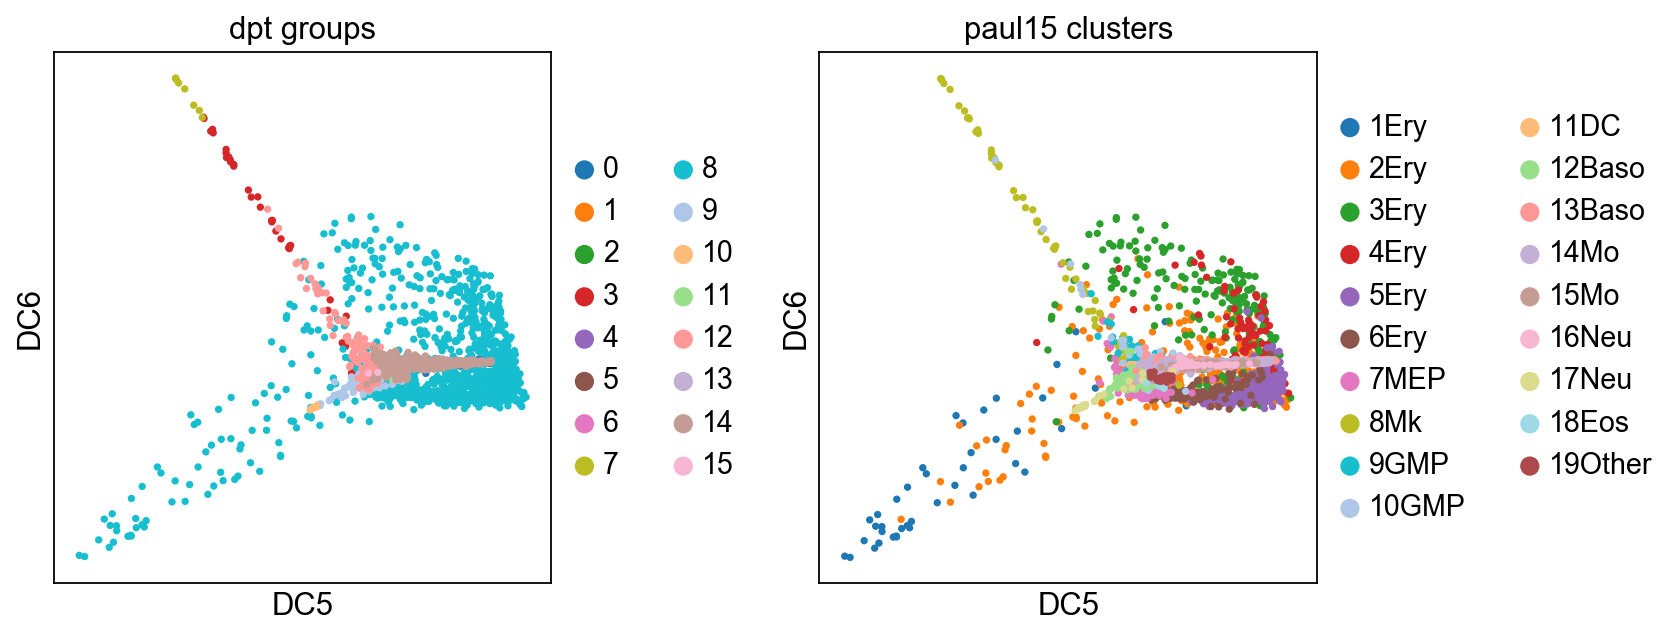

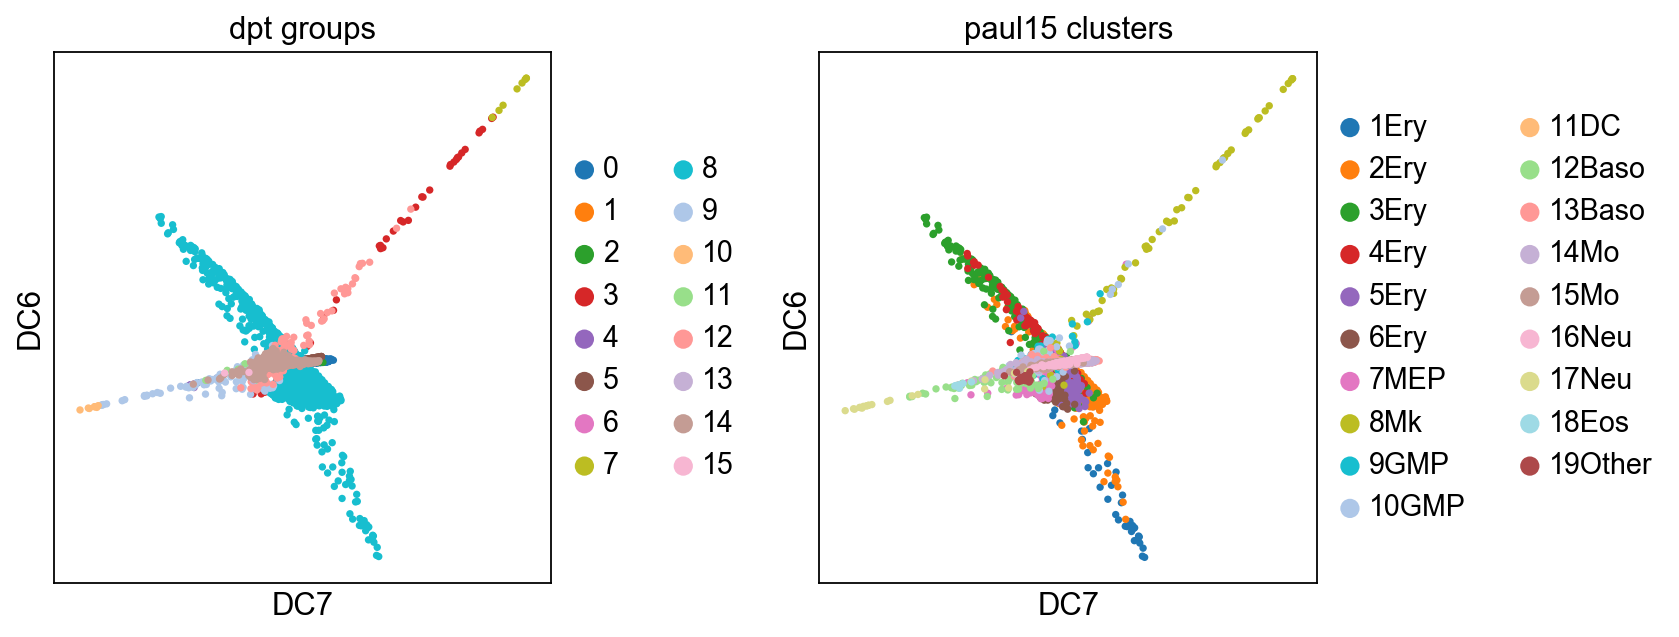

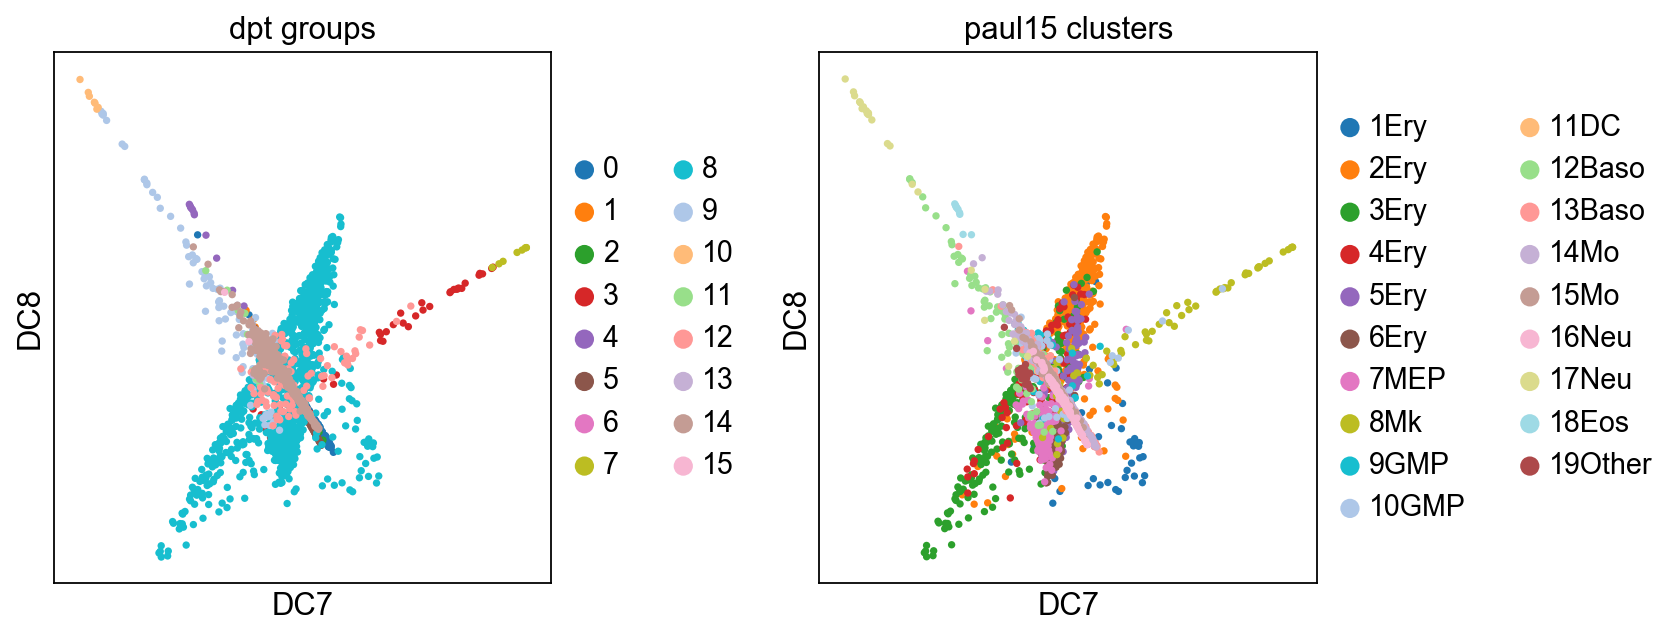

In [11]:
axs = sc.pl.diffmap(adata, color=['dpt_groups', 'paul15_clusters'],
                    comps=['1,2', '3,2', '3,4', '5,4', '5,6', '7,6', '7,8'],
                    right_margin=0.35)

#### Two different ways of identifying the DPT groups

normalized by reference groups (along columns)


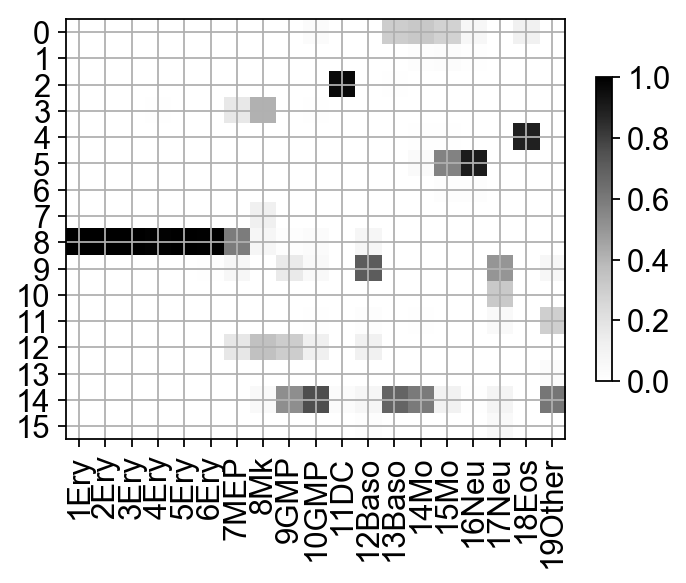

normalized by predicted groups (along rows)


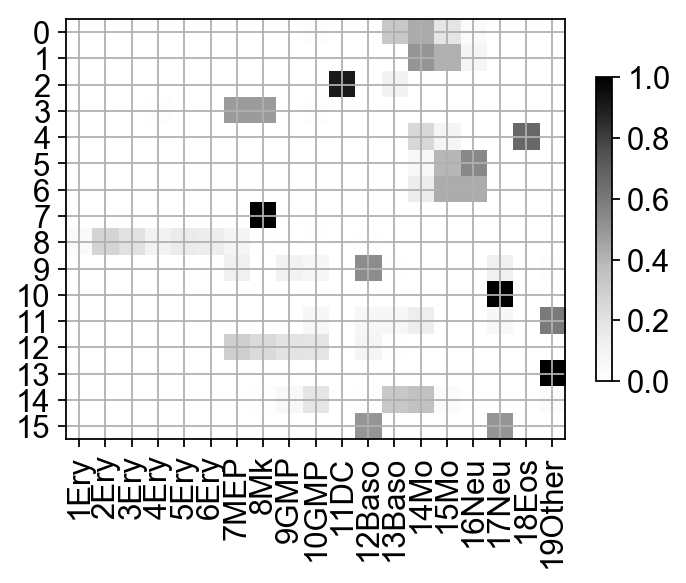

In [12]:
for normalization in ['reference', 'predicted']:
    print('normalized by', normalization, 'groups',
          '(along columns)' if normalization == 'reference' else '(along rows)')
    asso_names, asso_matrix = sc.utils.identify_categories(
        adata, 'dpt_groups', 'paul15_clusters', normalization=normalization, threshold=0.01, max_number=3)
    sc.pl.matrix(asso_matrix, 
                 xlabels=adata.add['paul15_clusters_names'], 
                 ylabels=adata.add['dpt_groups_names'], 
                 cshrink=0.5)

Output the tree. This detects 8 meaningful cell fates.

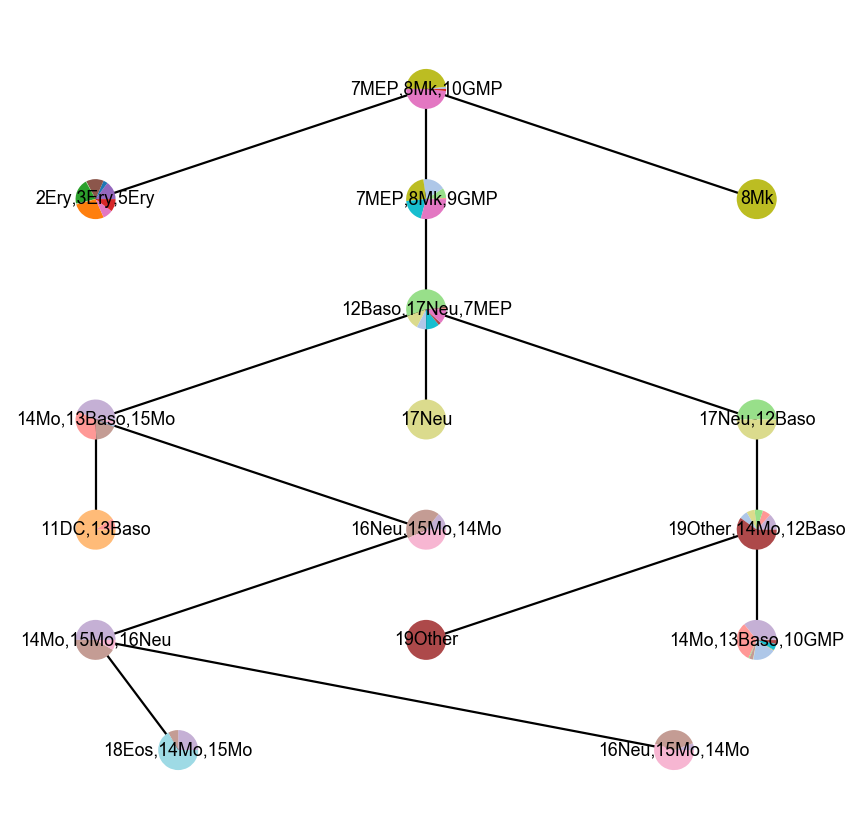

In [13]:
dpt_groups_pies = [
    {sc.pl.utils.pal_20[j]: asso_matrix[i, j] 
     for j in range(asso_matrix.shape[1])}
     for i in range(asso_matrix.shape[0])]
node_names = {iname: name for iname, name in enumerate(asso_names)}

ax = sc.pl.dpt_tree(adata, root=3, colors=dpt_groups_pies, names=asso_names, fontsize=8)

In [14]:
sc.write('paul15', adata)

... writing ./write/paul15.h5
